# Model Training Dataset
* Training on train dataset using m-estimate encoder value for category columns.

##Importing required libraries

In [0]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser as dparser
import random
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install category_encoders
from category_encoders import *

     |████████████████████████████████| 102kB 2.4MB/s 


## Mount Google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import train data

In [0]:
train=pd.read_csv(path+'train-data.csv', header=0)
train.head()

,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier
0,Week 1 of 2019,Warehouse Retailers,3,377.1,0,0.0,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7
1,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7
2,Week 1 of 2019,Warehouse Retailers,4,589.8,0,0.0,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7
3,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_1c00e,route_67047,supplier_identifier_055f7
4,Week 1 of 2019,Warehouse Retailers,3,343.8,0,0.0,store_fc6aa,product_55001,route_67047,supplier_identifier_055f7


## Data pre-processing

In [0]:
data = train.copy()
data.shape

(53364883, 10)

### Generating column demand
* Column for unit of demand is generated by subtracting units returned by units sold in week

In [0]:
data['demand'] = data['num_units_sold_in_week'] - data['num_units_returned']

### Generating values for each value in category columns using m-estimator
* Values for each unique entry in category column is generated by grouping the data with column and mean of demand column.

In [0]:
catAttributes = ['channel_type','product_identifier','category_of_route','supplier_identifier','store_identifier', 'experiment_week']
for c in catAttributes:
  X = data.loc[:, [c, 'num_units_sold_in_week', 'num_units_returned']].values
  y = data.loc[:, 'demand']

  enc = MEstimateEncoder(catAttributes).fit(X, y)
  data = pd.concat([data, enc.transform(X)[0]], axis=1)
  del enc
  del X
  del y

In [0]:
data.head()

,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier,demand,0,0,0,0,0,0
0,Week 1 of 2019,Warehouse Retailers,3,377.1,0,0.0,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7,3,15.017396,2.892020,18.36635,15.317068,5.575487,6.917377
1,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7,4,15.017396,3.097105,18.36635,15.317068,5.575487,6.917377
2,Week 1 of 2019,Warehouse Retailers,4,589.8,0,0.0,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7,4,15.017396,3.207035,18.36635,15.317068,5.575487,6.917377
3,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_1c00e,route_67047,supplier_identifier_055f7,4,15.017396,5.702624,18.36635,15.317068,5.575487,6.917377
4,Week 1 of 2019,Warehouse Retailers,3,343.8,0,0.0,store_fc6aa,product_55001,route_67047,supplier_identifier_055f7,3,15.017396,5.133844,18.36635,15.317068,5.575487,6.917377


### Generate new dataset with generated columns and demand

In [0]:
col = ['experiment_week', 'channel_type', 'num_units_sold_in_week',	'sales_revenue_in_week',	'num_units_returned',	'returned_units_revenue_loss', 'store_identifier', 'product_identifier', 'category_of_route', 'supplier_identifier', 'demand', 'val1', 'val2', 'val3', 'val4', 'val5', 'val6']
data.columns = col

data = data.loc[:, ['experiment_week', 'val1', 'val2', 'val3', 'val4', 'val5', 'val6', 'demand']]
data.dtypes

experiment_week     object
val1               float64
val2               float64
val3               float64
val4               float64
val5               float64
val6               float64
demand               int64
dtype: object

In [0]:
data.head()

,experiment_week,val1,val2,val3,val4,val5,val6,demand
0,Week 1 of 2019,15.017396,2.892020,18.36635,15.317068,5.575487,6.917377,3
1,Week 1 of 2019,15.017396,3.097105,18.36635,15.317068,5.575487,6.917377,4
2,Week 1 of 2019,15.017396,3.207035,18.36635,15.317068,5.575487,6.917377,4
3,Week 1 of 2019,15.017396,5.702624,18.36635,15.317068,5.575487,6.917377,4
4,Week 1 of 2019,15.017396,5.133844,18.36635,15.317068,5.575487,6.917377,3


### Converting numerical to float32 datatype
* To save memory on RAM, converting numerical to float32 datatype from float64

In [0]:
num = ['val1', 'val2', 'val3', 'val4', 'val5', 'val6']
for c in num:
  data[c] = data[c].astype('float32')
data.dtypes

experiment_week     object
val1               float32
val2               float32
val3               float32
val4               float32
val5               float32
val6               float32
demand               int64
dtype: object

### Correlation chart between numerical attributes

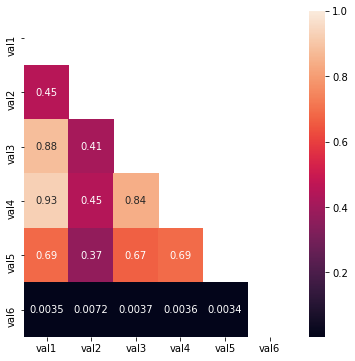

In [0]:
corr = data[num].corr()
fig, ax = plt.subplots(figsize=(6, 6)) 
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(corr, mask= mask, ax= ax, annot= True)

In [0]:
data.drop('val6', axis=1, inplace=True)
num.remove('val6')

## Training and testing models

### Defining function for matrice.
* RMSE is the matrice used.

In [0]:
def matrice(model):
  y_predicted = model.predict(X_train)
  print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_predicted)))
  
  y_predicted = model.predict(X_test)
  print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_predicted)))

### Index of Starting of Week 5 data

In [0]:
indx = data[data['experiment_week'] == 'Week 5 of 2019'].index[0]
indx

42982034

### Splitting train and validation data set

In [0]:
X_train = data.loc[:indx, num].values
X_test = data.loc[indx:, num].values

In [0]:
y_train = data.loc[:indx,'demand'].values
y_test = data.loc[indx:,'demand'].values
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42982035, 5), (42982035,), (10382849, 5), (10382849,))

### Modeling using Linear Regression

In [0]:
linearRegression = LinearRegression()  
linearRegression = linearRegression.fit(X_train, y_train)

In [0]:
matrice(linearRegression)

Train RMSE:  17.00756899492275
Test RMSE:  16.82492615887398


### Modeling using Decision Tree

In [0]:
decisionTree = tree.DecisionTreeRegressor()
decisionTree = decisionTree.fit(X_train, y_train)

In [0]:
matrice(decisionTree)

Train RMSE:  0.061992505316969565
Test RMSE:  12.918783671598838


### Modeling using Random Forest

In [0]:
randomForest = RandomForestRegressor()
randomForest = randomForest.fit(X_train, y_train)

In [0]:
matrice(randomForest)

Train RMSE:  8.72161142103015
Test RMSE:  16.037320099257165
